In [40]:
%pip install openpyxl datasets gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

adjust = 0
classes = 2


# #SST2 dataset
# train_file = pd.read_csv('datasets/SST2_TestData.csv')
# train_dataset = Dataset.from_pandas(train_file)
# dataset = load_dataset('sst2')
# dataset = DatasetDict({
#     'train': dataset['train'],
#     'validation': dataset['validation'],
#     'test': train_dataset
# })
# text = 'sentence'
# label = 'label'


# #SST5 dataset
# dataset = load_dataset('SetFit/sst5')
# print(dataset['train'][10])
# text = 'text'
# label = 'label'
# classes = 5


#Aug24-Assignment1-Dataset1
train_file = pd.read_excel('datasets/Aug24-Assignment1-Dataset1.xlsx')
val_file = pd.read_excel('datasets/Aug24-Assignment1-Validation-Dataset1.xlsx')
# test_file = pd.read_excel('datasets/Aug24-Assignment1-Test-Dataset1.xlsx')
test_file = pd.read_excel('datasets/Aug24-Assignment1-Dataset1-test.xlsx')
train_dataset = Dataset.from_pandas(train_file)
val_dataset = Dataset.from_pandas(val_file)
test_dataset = Dataset.from_pandas(test_file)
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
label = 'overall'
text = 'reviewText'
adjust = 1
classes = 5





print(set(dataset['train'][label]))
print(dataset)

{1, 2, 3, 4, 5}
DatasetDict({
    train: Dataset({
        features: ['overall', 'reviewText'],
        num_rows: 3999
    })
    validation: Dataset({
        features: ['overall', 'reviewText'],
        num_rows: 802
    })
    test: Dataset({
        features: ['overall', 'reviewText'],
        num_rows: 916
    })
})


In [42]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# # Download necessary NLTK data files
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# # Load stop words
# stop_words = set(stopwords.words('english'))

# # Initialize lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Preprocess a single sentence
# def preprocess_sentence(sentence):
#     if not isinstance(sentence, str):
#         return []
#     # Tokenize
#     tokens = word_tokenize(sentence)
#     # Lowercase
#     tokens = [word.lower() for word in tokens]
#     # Remove punctuation
#     tokens = [word for word in tokens if word.isalnum()]
#     # Remove stop words
#     tokens = [word for word in tokens if word not in stop_words]
#     # Lemmatize
#     tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     return tokens

# # Apply preprocessing to the dataset
# def preprocess_dataset(dataset):
#     for split in ['train', 'validation']:
#         dataset[split] = dataset[split].map(lambda example: {'reviewText': preprocess_sentence(example[label])})
#     return dataset

# # Preprocess the dataset
# dataset = preprocess_dataset(dataset)

# # Verify the preprocessing
# print(dataset['train'][0])
# print(dataset['validation'][0])

In [43]:
import gensim.downloader as api

#Load pre-trained word embeddings
# vector_representation = api.load('word2vec-google-news-300')
# vector_representation = api.load('glove-wiki-gigaword-300')
# vector_representation = api.load('fasttext-wiki-news-subwords-300')

In [44]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def sentence_to_matrix(sentence, vector_representation, max_len):
    sentence = str(sentence)
    words = sentence.split()
    matrix = np.zeros((max_len, vector_representation.vector_size))
    for i, word in enumerate(words):
        if i >= max_len:
            break
        if word in vector_representation:
            matrix[i] = vector_representation[word]
    return matrix

def create_dataloader(texts, labels, vector_representation, max_len, batch_size=32, shuffle=False): 
    matrices = [sentence_to_matrix(text, vector_representation, max_len) for text in texts]
    labels = torch.tensor(labels) - adjust  # Adjust labels to start from 0
    matrices = torch.tensor(matrices, dtype=torch.float32)
    dataset = TensorDataset(matrices, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

#Parameters
# print(dataset['train'][1010])
max_len = 50
batch_size = 32

train_text = dataset['train'][text]
test_text = dataset['test'][text]
valdation_text = dataset['validation'][text]

train_labels = dataset['train'][label]
test_labels = dataset['test'][label]
# test_labels = list(np.zeros(len(dataset['test'][text])))
valdation_labels = dataset['validation'][label]

train_dataloader = create_dataloader(train_text, train_labels, vector_representation, max_len, batch_size)
test_dataloader = create_dataloader(test_text, test_labels, vector_representation, max_len, batch_size)
valdation_dataloader = create_dataloader(valdation_text, valdation_labels, vector_representation, max_len, batch_size)

for batch in train_dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([32, 50, 300])
torch.Size([32])


3999 916
Training Set Sentence Lengths:
Mean: 49.66
Median: 33.00
Max: 1037

Test Set Sentence Lengths:
Mean: 53.87
Median: 32.00
Max: 1554


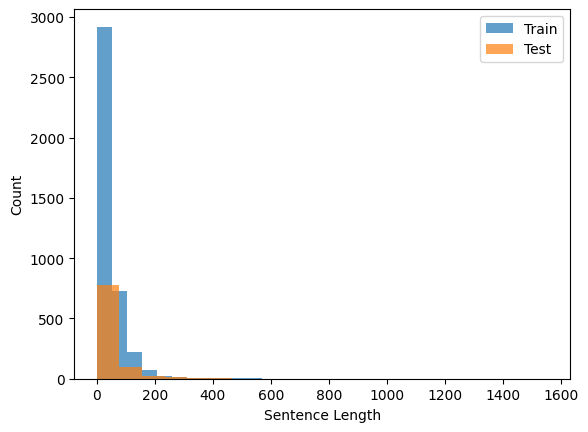

In [45]:
def calculate_sentence_length(dataset):
    lengths = []
    for sentence in dataset[text]:
        sentence = str(sentence)
        lengths.append(len(sentence.split()))
    return lengths

train_lengths = calculate_sentence_length(dataset['train'])
test_lengths = calculate_sentence_length(dataset['test'])

print(len(train_lengths), len(test_lengths))

# Print statistics
print("Training Set Sentence Lengths:")
print(f"Mean: {np.mean(train_lengths):.2f}")
print(f"Median: {np.median(train_lengths):.2f}")
print(f"Max: {np.max(train_lengths)}")

print("\nTest Set Sentence Lengths:")
print(f"Mean: {np.mean(test_lengths):.2f}")
print(f"Median: {np.median(test_lengths):.2f}")
print(f"Max: {np.max(test_lengths)}")

#visualize the distribution of sentence lengths
import matplotlib.pyplot as plt
#printing mean, median and max of the sentence lengths
plt.hist(train_lengths, bins=20, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=20, alpha=0.7, label='Test')
plt.legend()
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.show()


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Parameter(torch.randn(embedding_dim, embedding_dim))

    def forward(self, x):
        return torch.matmul(x, self.embedding)

class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim, maxlen, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 700, (3, embedding_dim), padding=(1, 0))  # 100 filters, kernel size (3, embedding_dim), padding to maintain size
        self.conv2 = nn.Conv2d(1, 700, (4, embedding_dim), padding=(2, 0))  # 100 filters, kernel size (4, embedding_dim), padding to maintain size
        self.conv3 = nn.Conv2d(1, 700, (5, embedding_dim), padding=(2, 0))  # 100 filters, kernel size (5, embedding_dim), padding to maintain size
        self.maxpool = nn.MaxPool1d(maxlen)  
        self.fc1 = nn.Linear(700 * 3, 500)  
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x,embed=False):
        #x = self.embedding(x).unsqueeze(1)  # Add channel dimension
        x = x.unsqueeze(1)  # Add channel dimension
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x1 = self.maxpool(x1).squeeze(2)
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x2 = self.maxpool(x2).squeeze(2)
        x3 = F.relu(self.conv3(x)).squeeze(3)
        x3 = self.maxpool(x3).squeeze(2)
        x = torch.cat((x1, x2, x3), 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        if embed:
            return x
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Parameters
embedding_dim = 300
maxlen = 50
num_classes = classes  # Example number of classes

# Initialize the model
model = CNNClassifier(embedding_dim, maxlen, num_classes)

# Example input
input_data = torch.randn(32, maxlen, embedding_dim)  # Batch size 32, sequence length maxlen, input_dim 300
output = model(input_data)
print(output.shape)  # Should be (32, num_classes)

torch.Size([32, 5])


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [48]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(valdation_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 93.0713672041893
Accuracy: 79.93%
Epoch 2, Loss: 76.90608522295952
Accuracy: 79.80%
Epoch 3, Loss: 60.43021450936794
Accuracy: 79.43%
Epoch 4, Loss: 40.91895546391606
Accuracy: 76.43%
Epoch 5, Loss: 24.53950598463416
Accuracy: 79.55%
Epoch 6, Loss: 21.302244815975428
Accuracy: 71.82%
Epoch 7, Loss: 20.447398174437694
Accuracy: 45.89%
Epoch 8, Loss: 17.481292229727842
Accuracy: 73.82%
Epoch 9, Loss: 2.400750257249456
Accuracy: 77.93%
Epoch 10, Loss: 0.8845690950984135
Accuracy: 77.81%


In [49]:
print("Test Set Evaluation")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
       
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Test Set Evaluation
Accuracy: 80.13%


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

correct = 0
total = 0
actual_labels = []
predicted_labels = []


with torch.no_grad():
    for inputs, labels in test_dataloader:
    # for inputs, labels in valdation_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        actual_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(len(actual_labels), len(predicted_labels))

# predicted_labels = [x + adjust for x in predicted_labels]
# save predictions in new excel file
# test_result = pd.read_excel('datasets/Aug24-Assignment-Dataset1-test-predicted.xlsx')
# test_result['predicted'] = predicted_labels
# test_result.to_excel('datasets/Aug24-Assignment-Dataset1-test-predicted.xlsx', index=False)

accuracy = 100 * correct / total
precision = precision_score(actual_labels, predicted_labels, average='macro')
recall = recall_score(actual_labels, predicted_labels, average='macro')
macro_f1 = f1_score(actual_labels, predicted_labels, average='macro')
micro_f1 = f1_score(actual_labels, predicted_labels, average='micro')

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Macro F1 Score: {macro_f1:.2f}')
print(f'Micro F1 Score: {micro_f1:.2f}')
print(confusion_matrix(actual_labels, predicted_labels))


916 916
Accuracy: 80.13%
Precision: 0.45
Recall: 0.32
Macro F1 Score: 0.32
Micro F1 Score: 0.80
[[ 27   2   1   1  19]
 [  7   0   0   1  10]
 [  4   0   2   2  28]
 [  3   0   0   3  88]
 [  6   1   0   9 702]]


In [51]:
# # temp_labels = predicted_labels
# print(len(temp_labels), len(actual_labels))
# micro_f1 = f1_score(actual_labels, temp_labels, average='micro')
# print(f'Micro F1 Score: {micro_f1:.2f}')